In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

import joblib
import pickle

### Objectifs
L'analyse de sentiment consiste à détecter les émotions et attitudes d'un énonciateur à l'égard d'un sujet donné dans un texte. Pour ce faire, nous allons utiliser des techniques de traitement du langage naturel pour extraire des features de chaque texte, qui seront utilisées comme entrées pour nos modèles de classification.

Pour entraîner nos modèles, nous allons d'abord diviser nos données en deux ensembles: l'ensemble d'entraînement et l'ensemble de test. Nous utiliserons l'ensemble d'entraînement pour entraîner nos modèles et l'ensemble de test pour évaluer leur performance.

Ensuite, nous allons entraîner nos modèles de classification de texte sur l'ensemble d'entraînement en utilisant des unigrammes, des bigrammes et des trigrammes comme features d'entrée. Une fois que nos modèles sont entraînés, nous les évaluerons sur l'ensemble de test en utilisant une mesure de performance telle que l'exactitude.

Enfin, nous comparerons les résultats obtenus avec chacun de nos modèles pour déterminer lequel a obtenu les meilleures performances. Cela nous permettra de déterminer si l'utilisation de n-grammes de différentes tailles a eu un impact sur la performance des modèles d'analyse de sentiment.

In [3]:
train_df = pd.read_csv("../data/train_data.csv")
test_df = pd.read_csv("../data/test_data.csv")

In [4]:
train_df.head()

,Reviews,Rating,nombre-mots-reviews,longueur-reviews
0,nice practical basic but not cheap very resist...,4,14,80
1,phone grab all function of samsung note then t...,5,41,216
2,have phone for day love buy neon orange phone ...,5,20,99
3,a person of trash send only empty box without ...,1,11,63
4,want phone to good promising but keep turn its...,1,30,163


## Entrainement de plusieurs modèles

In [5]:
from sklearn.metrics import classification_report, confusion_matrix

# fonction pour diminuer la tailles du jeu de donn.es en fonction de la longueur des critiques
def cut_data(length):
    i1 = train_df[train_df["longueur-reviews"]>=length].index
    i2 = test_df[test_df["longueur-reviews"]>=length].index
    train_ = train_df.drop(i1).reset_index(drop=True)
    test_ = test_df.drop(i2).reset_index(drop=True)
    return train_, test_

# fonction pour vectoriser
def vectorize(ngrams, train_data, test_data):
    vectorizer = TfidfVectorizer(ngram_range=ngrams)
    vectorized1 = vectorizer.fit_transform(train_data['Reviews'])
    vectorized2 = vectorizer.transform(test_data["Reviews"])
    vector_train = vectorized1.toarray()
    vector_test = vectorized2.toarray()
    print("Somme 5 premiers vecteurs")
    print("Train: ")
    print(vector_train.sum(axis=0)[:5])
    print("Test: ")
    print(vector_test.sum(axis=0)[:5])

    print("Vocabulaire")
    print(vectorizer.get_feature_names_out()[100:150])
    return vector_train, vector_test, vectorizer

def train_classifier(classifier, train_X, train_y, test_X, test_y):

    # Entraîner le classifieur sur les données d'entraînement
    classifier.fit(train_X, train_y)

    y_pred = classifier.predict(test_X)
    target_names=["1", "2", "3", "4", "5"]
    classification_score = classification_report(test_y, y_pred, target_names=target_names)
    cm = confusion_matrix(test_y, y_pred)

    print("Rapport de classification")
    print(classification_score)
    print("-"*42)
    # Calculer les scores de précision et de rappel sur les données de test
    accuracy = classifier.score(test_X, test_y)
    print("Accuracy: {}".format(accuracy))

    return y_pred, classification_score, cm

### Modèle avec les unigrammes

####  > Reviews de longueurs < 75 avec des unigrammes

Nous allons réduire la taille des reviews en ne conservant que les reviews de moins de 75 lettres.

In [6]:
train_75, test_75 = cut_data(75)

In [7]:
train_75.head()

,Reviews,Rating,nombre-mots-reviews,longueur-reviews
0,a person of trash send only empty box without ...,1,11,63
1,order a iphone get a iphone not coo,1,8,35
2,love excellen,5,2,13
3,unlocked to mobile great quality for camera ba...,5,9,55
4,excellen,5,1,8


In [8]:
train_75.shape

(151991, 4)

In [9]:
train_vectors_X75, test_vectors_X75, vectorizer_75 = vectorize((1,1), train_75, test_75)

Somme 5 premiers vecteurs
Train: 
[31.73611054  6.99578902  2.29380784  7.          1.        ]
Test: 
[11.62819893  5.52438021  5.51398684  3.93637014  0.86014987]
Vocabulaire
['acording' 'acquist' 'acro' 'across' 'act' 'actio' 'activ' 'activado'
 'activat' 'activate' 'activatible' 'activatin' 'activating' 'activatio'
 'activation' 'active' 'activiate' 'activity' 'actual' 'actualizaed'
 'actualization' 'actuall' 'actually' 'actuly' 'acurate' 'ad' 'adapt'
 'adaptarme' 'adaptatio' 'adaptator' 'adapte' 'adapter' 'adaptive'
 'adapto' 'adaptor' 'adatopr' 'add' 'adde' 'addict' 'addicted' 'addictio'
 'addiction' 'additional' 'addre' 'address' 'addvertiz' 'adecuado'
 'ademas' 'adequat' 'adequate']


##### Classificateur de bayes multinomial

![bayes classifier](https://storage.googleapis.com/coderzcolumn/static/tutorials/machine_learning/article_image/Scikit-Learn%20-%20Naive%20Bayes.jpg)

---
Le classificateur de Bayes multinomial est un modèle de classification probabiliste qui utilise une approche de type "bag of words" pour prédire la classe d'un document en fonction de ses mots individuels. Il utilise le théorème de Bayes pour estimer la probabilité d'appartenance d'un document à chaque classe en fonction de ses mots.

Voici comment fonctionne le classificateur de Bayes multinomial:

> 1. Création du vocabulaire: Tout d'abord, le classificateur crée un vocabulaire des mots uniques présents dans les documents d'entraînement.
> 2. Calcul des probabilités de chaque mot: Pour chaque mot du vocabulaire, le classificateur calcule la probabilité de ce mot dans chaque classe.
> 3. Calcul des probabilités de chaque classe: Le classificateur calcule également la probabilité de chaque classe en fonction de la fréquence de chaque classe dans les documents d'entraînement.
> 4. Prédiction de la classe d'un document: Lorsqu'on lui demande de prédire la classe d'un nouveau document, le classificateur utilise le théorème de Bayes pour calculer la probabilité de chaque classe en fonction des probabilités de chaque mot du vocabulaire dans chaque classe. La classe qui a la plus haute probabilité est alors sélectionnée comme classe prédite.

In [10]:
# definition du modele
model_nb_75 = MultinomialNB()

In [11]:
%%time
y_pred_nb, clf_score_nb, conf_mat_nb = train_classifier(classifier=model_nb_75, train_X=train_vectors_X75, train_y=train_75.Rating, test_X=test_vectors_X75, test_y=test_75.Rating)

Rapport de classification
              precision    recall  f1-score   support

           1       0.68      0.77      0.72      8034
           2       0.75      0.05      0.10      2248
           3       0.69      0.13      0.22      3408
           4       0.54      0.13      0.21      8311
           5       0.79      0.98      0.88     42222

    accuracy                           0.77     64223
   macro avg       0.69      0.41      0.43     64223
weighted avg       0.74      0.77      0.71     64223

------------------------------------------
Accuracy: 0.767139498310574
CPU times: total: 1min 44s
Wall time: 52.2 s


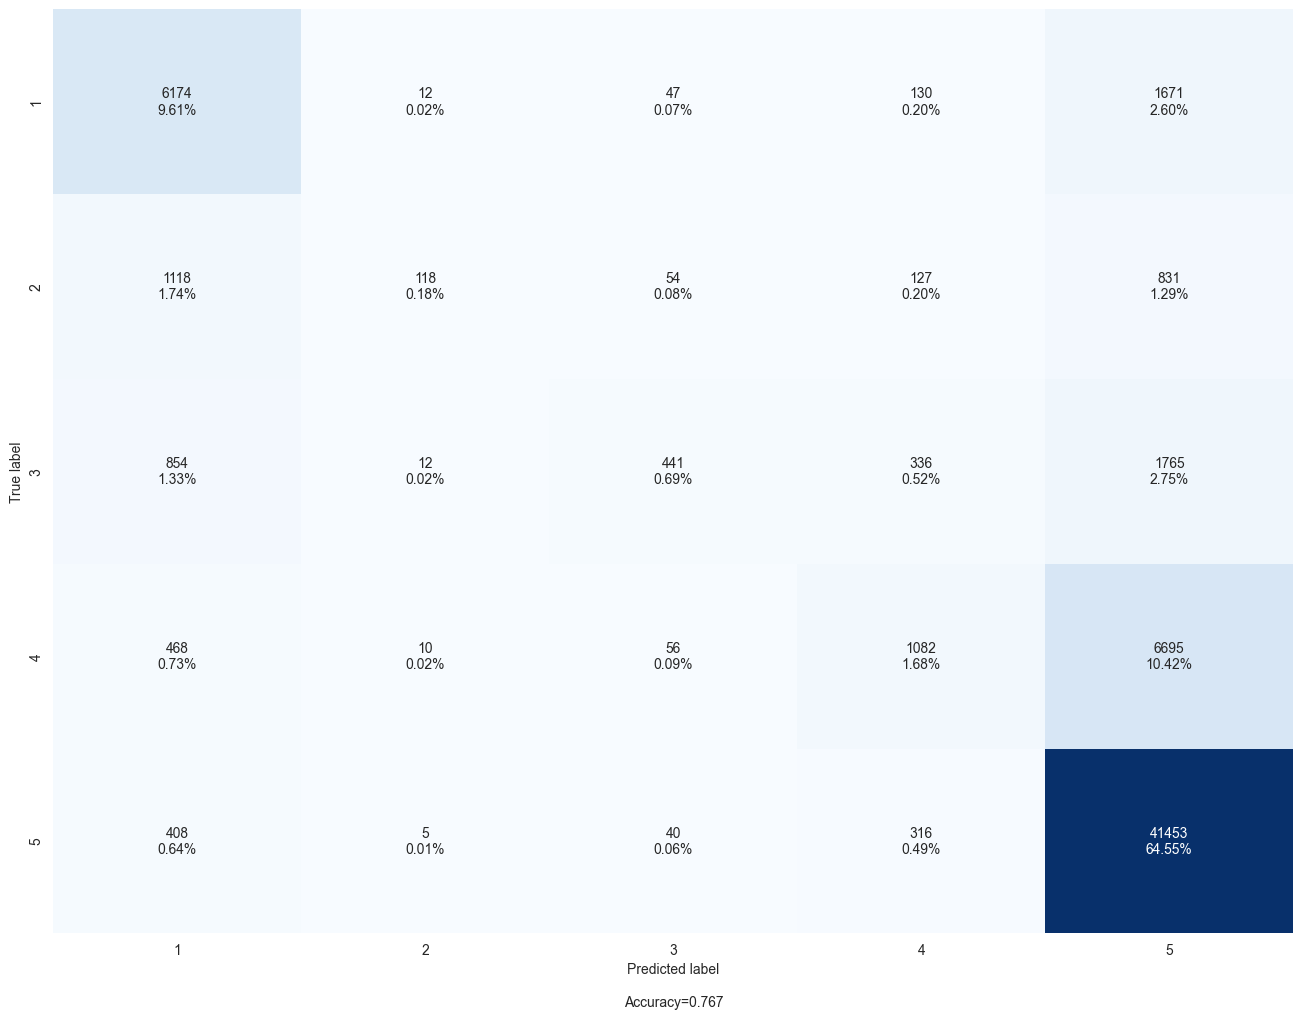

In [12]:
from utils.confusion_matrix_plot import make_confusion_matrix
labels = ["1", "2", "3", "4", "5"]
make_confusion_matrix(conf_mat_nb, group_names=labels, categories=labels, figsize=(16, 12), cbar=False)

##### classifieur Forêt Aléatoire

![random forest classifier](https://miro.medium.com/max/1200/1*hmtbIgxoflflJqMJ_UHwXw.jpeg)

---
Un classifieur Random Forest est un algorithme d'apprentissage automatique supervisé basé sur des arbres de décision.
Le fonctionnement d'un classifieur Random Forest est assez simple. Voici les étapes principales :

1. Générer N arbres de décision à partir de l'ensemble de données. Pour chaque arbre, on effectue un échantillon aléatoire de l'ensemble de données avec remplacement (on appelle ça un échantillon bootstrap) et on utilise cet échantillon pour entraîner l'arbre.

2. Pour chaque arbre, faire une prédiction sur les données de test.

3. Agréger les prédictions de chaque arbre en prenant la majorité vote (pour une tâche de classification) ou en prenant la moyenne (pour une tâche de régression).

L'utilité d'un classifieur Random Forest dans un problème d'analyse de sentiment réside dans sa capacité à faire des prédictions précises en utilisant un ensemble de modèles de décision qui sont légèrement différents les uns des autres. Comme chaque arbre de décision utilisé dans le classifieur a été entraîné sur un échantillon légèrement différent de l'ensemble de données, il y a moins de risque de surapprentissage (quand un modèle "memorise" trop bien les données d'entraînement et a du mal à généraliser sur de nouvelles données). En agrégeant les prédictions de chaque arbre, le classifieur Random Forest peut également être plus robuste aux bruits présents dans les données et aux erreurs de classification de chaque arbre individuel.

In [13]:
n_estimators = 10
model_rf_75 = RandomForestClassifier(n_estimators =n_estimators,criterion="entropy",random_state =0)

In [14]:
%%time
y_pred_rf, clf_score_rf, conf_mat_rf = train_classifier(classifier=model_rf_75, train_X=train_vectors_X75, train_y=train_75.Rating, test_X=test_vectors_X75, test_y=test_75.Rating)

Rapport de classification
              precision    recall  f1-score   support

           1       0.78      0.88      0.83      8034
           2       0.83      0.51      0.63      2248
           3       0.82      0.52      0.63      3408
           4       0.79      0.39      0.53      8311
           5       0.87      0.97      0.92     42222

    accuracy                           0.85     64223
   macro avg       0.82      0.65      0.71     64223
weighted avg       0.84      0.85      0.83     64223

------------------------------------------
Accuracy: 0.8464101645827818
CPU times: total: 4min 2s
Wall time: 7min 58s


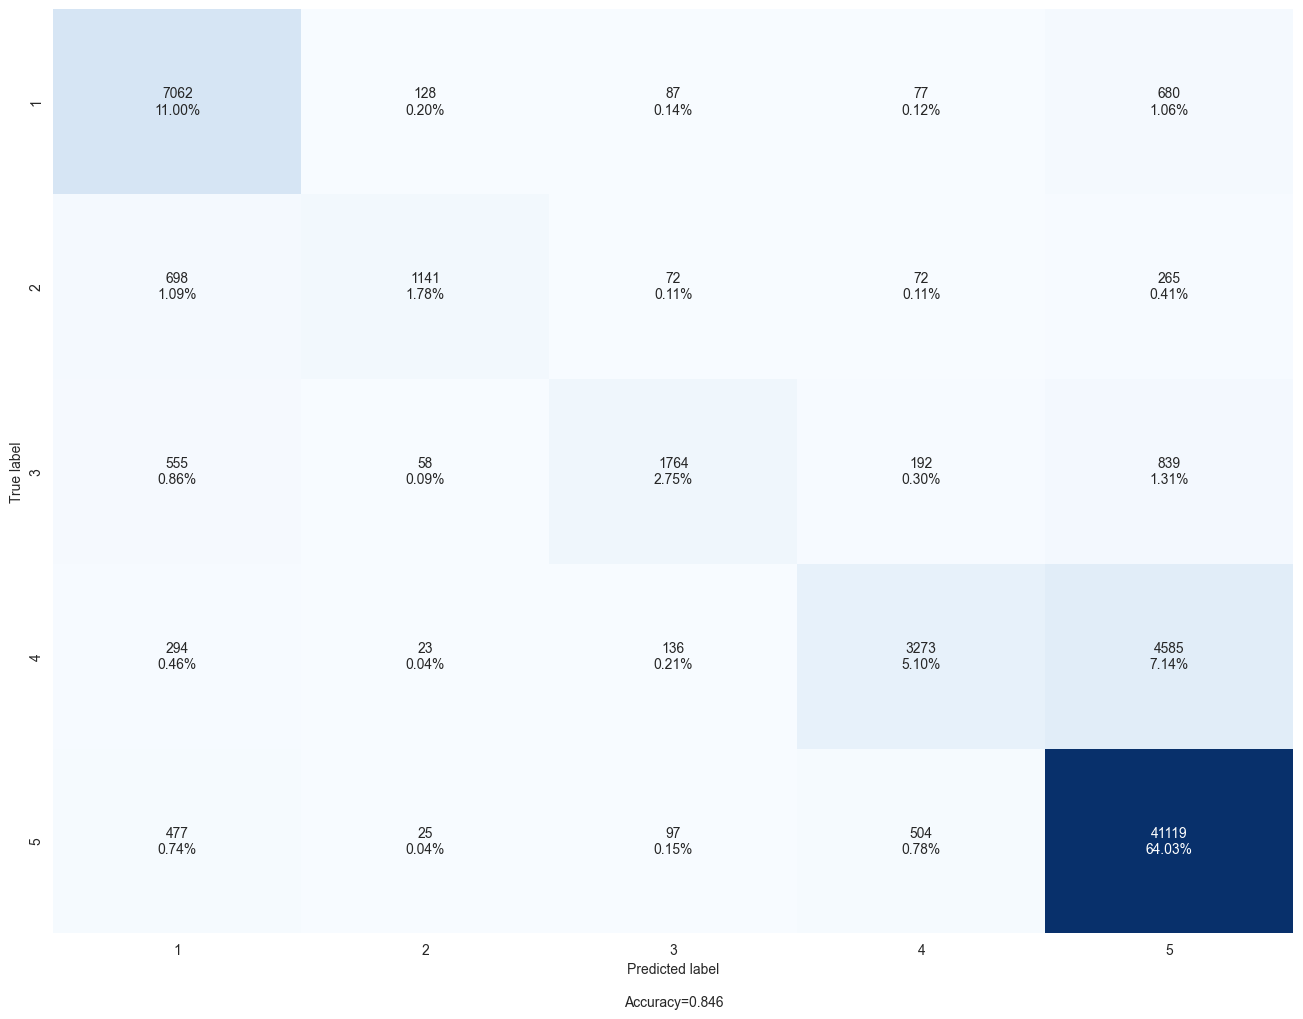

In [15]:
make_confusion_matrix(conf_mat_rf, group_names=labels, categories=labels, figsize=(16, 12), cbar=False)

####  > Reviews de longueurs < 25 avec des bigrammes

In [16]:
train_25, test_25 = cut_data(25)

In [17]:
train_vectors_X25_bi, test_vectors_X25_bi, vectorizer_25 = vectorize(ngrams=(2,2), train_data=train_25, test_data=test_25)

Somme 5 premiers vecteurs
Train: 
[1.         1.         0.87384614 2.47412303 1.43250491]
Test: 
[0.         2.         0.         0.55425079 0.        ]
Vocabulaire
['after first' 'after go' 'after ha' 'after mont' 'after month'
 'after mount' 'after one' 'after open' 'after purchas' 'after sale'
 'after short' 'after three' 'after two' 'after use' 'after we'
 'after wee' 'after week' 'after year' 'afternoon good' 'agree promise'
 'ah llegad' 'ahead of' 'ahora super' 'ajtyyjyj jy' 'al ajtyyjyj'
 'al destin' 'al goo' 'al on' 'al righ' 'al very' 'ala semana'
 'alcatel lov' 'algo car' 'algo mal' 'alittle slow' 'all accord'
 'all advertise' 'all affor' 'all aluminiu' 'all aroun' 'all around'
 'all ask' 'all aspect' 'all band' 'all be' 'all chippy' 'all come'
 'all coo' 'all crack' 'all cracke']


In [18]:
%%time
# definition du modele
model_nb_25bi = MultinomialNB()


y_pred_nb_bi, clf_score_nb_bi, conf_mat_nb_bi = train_classifier(classifier=model_nb_25bi, train_X=train_vectors_X25_bi, train_y=train_25.Rating, test_X=test_vectors_X25_bi, test_y=test_25.Rating)

Rapport de classification
              precision    recall  f1-score   support

           1       0.81      0.57      0.67      2568
           2       0.84      0.13      0.22       711
           3       0.90      0.13      0.23      1326
           4       0.79      0.10      0.18      4175
           5       0.80      1.00      0.89     25239

    accuracy                           0.80     34019
   macro avg       0.83      0.39      0.44     34019
weighted avg       0.81      0.80      0.75     34019

------------------------------------------
Accuracy: 0.8042270495899351
CPU times: total: 24.4 s
Wall time: 7.36 s


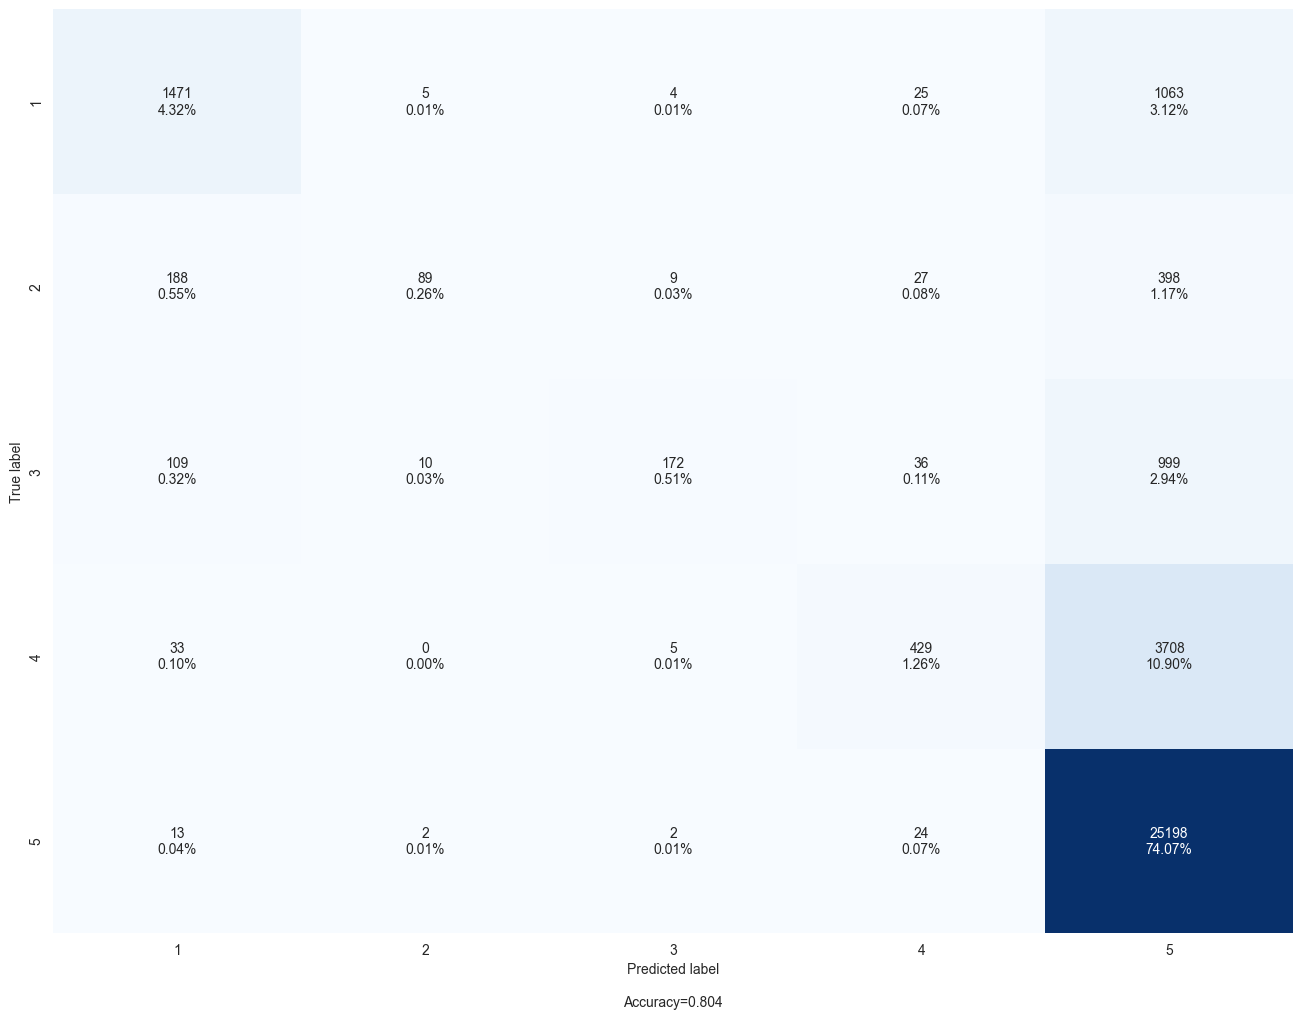

In [19]:
make_confusion_matrix(conf_mat_nb_bi, group_names=labels, categories=labels, figsize=(16, 12), cbar=False)

In [22]:
%%time
n_estimators = 10
model_rf_25_bi = RandomForestClassifier(n_estimators =n_estimators,criterion="entropy",random_state =0)

CPU times: total: 0 ns
Wall time: 0 ns


In [23]:
y_pred_rf_bi, clf_score_rf_bi, conf_mat_rf_bi = train_classifier(classifier=model_rf_25_bi, train_X=train_vectors_X25_bi, train_y=train_25.Rating, test_X=test_vectors_X25_bi, test_y=test_25.Rating)

Rapport de classification
              precision    recall  f1-score   support

           1       0.87      0.61      0.72      2568
           2       0.74      0.44      0.55       711
           3       0.81      0.33      0.47      1326
           4       0.72      0.19      0.30      4175
           5       0.83      0.99      0.90     25239

    accuracy                           0.82     34019
   macro avg       0.79      0.51      0.59     34019
weighted avg       0.81      0.82      0.79     34019

------------------------------------------
Accuracy: 0.8241570886857345


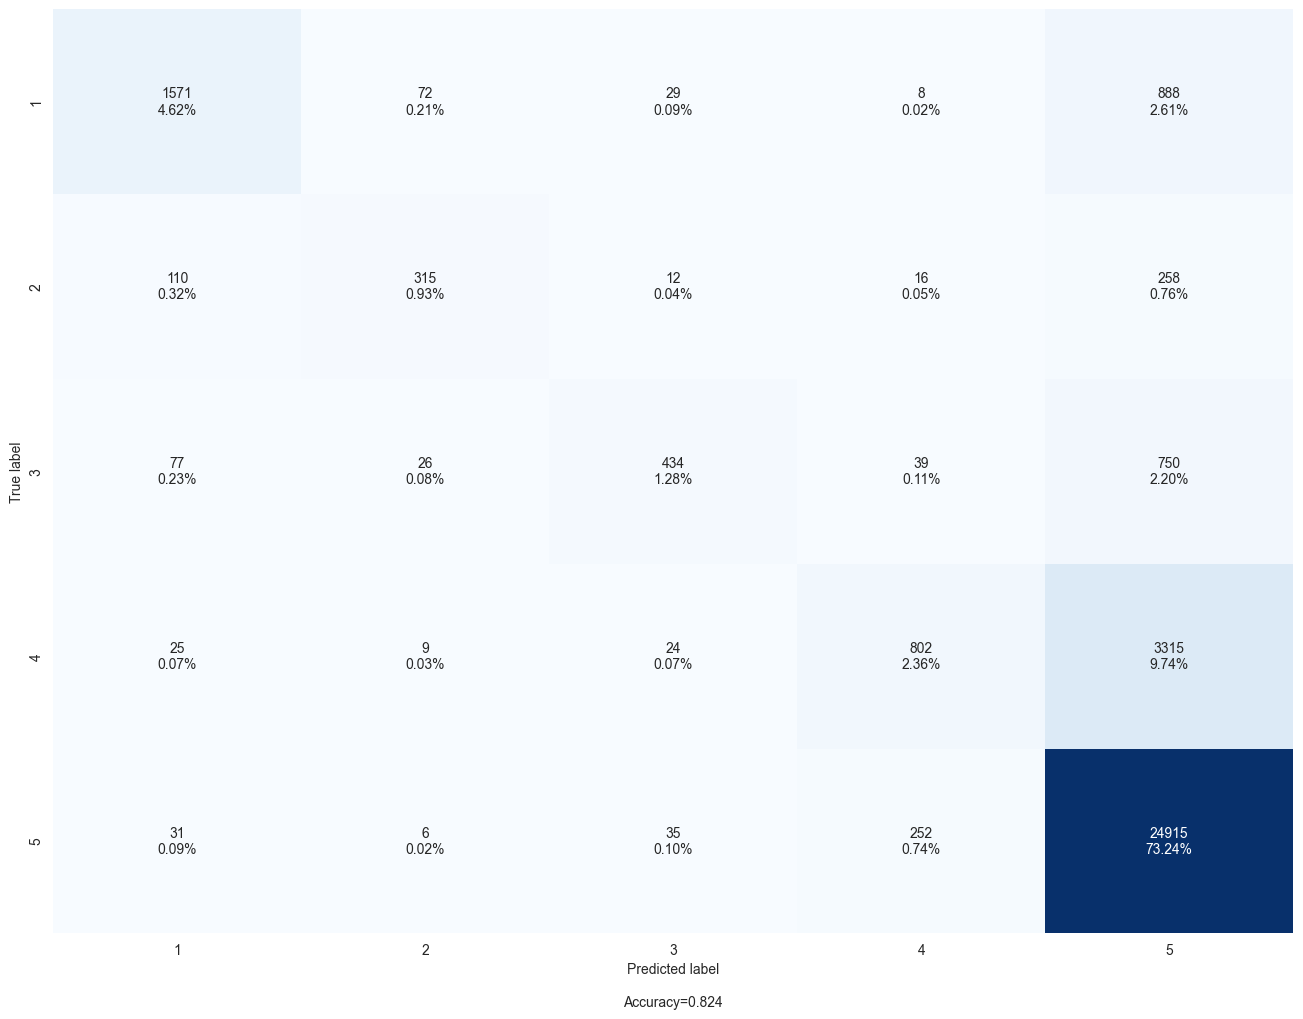

In [24]:
make_confusion_matrix(conf_mat_rf_bi, group_names=labels, categories=labels, figsize=(16, 12), cbar=False)

# sauvegarder les modèles

In [25]:
joblib.dump(model_rf_75, "../data/models/rf_model75.sav")
joblib.dump(model_nb_75, "../data/models/nb_model75.sav")

joblib.dump(model_rf_25_bi, "../data/models/rf_model25.sav")
joblib.dump(model_nb_25bi, "../data/models/nb_model25.sav")

['../data/models/nb_model25.sav']

- Sauvegarder les vectoriseur

In [27]:
pickle.dump(vectorizer_75, open("../data/vectorizer75.pickle", "wb"))
pickle.dump(vectorizer_25, open("../data/vectorizer25.pickle", "wb"))